In [1]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import jsonfix
from pprint import pprint
import csv
import scipy.signal
import datetime


In [2]:
data = jsonfix.fix_json("D:\\Research\\jordan.json")

lifeLog = data['lifeLog']

In [3]:
cal = []
for k in lifeLog:
    for r in lifeLog[k]["mobile"].values():
        if r == None:
            continue
        if "calendar" in r:
            for j in r["calendar"]["labeledCalendar"]:
                tw = r['time']['timeWindow'] 
                tw = tw[4:8] + "_"+ tw[0:4] + tw[8:]
                cal.append([j["event"], j["location"], j["startTime"], k, tw ])
    

In [4]:
cal_filtered = []
#filter same events from consecutive time windows
cal = sorted(cal,key=lambda x:x[0])
i = 0
while i < len(cal):
    cal_filtered.append(cal[i])
    #this becomes the length of the event
    cal_filtered[-1].append(0)
    prev = cal[i][:3]
    while cal[i][:3] == prev:
        cal_filtered[-1][-1] += 5
        i+=1
        if i >= len(cal):
            break
        
cal = cal_filtered

In [65]:
# classified_minute_windows = {}
# with open('symbolicResultWorking.csv') as f:
#     csvFile = csv.reader(f,delimiter=',')
#     prev = ''
#     total = 0
#     key_string = ''
#     for line in csvFile:
#         if int(line[0][-3:]) != prev:
#             key_string = line[0][:-7] + str(int(int(line[0][-7:-4])+total/5)) + line[0][-4:]
#             classified_minute_windows[key_string] = {'moving':[line[5]]}
#             classified_minute_windows[|key_string]['date'] = line[0:10]
#             prev = int(line[0][-3:])
#         else:
#             classified_minute_windows[key_string]['moving'].append(line[5])
#         total += 1
classified_minute_windows = []
with open('symbolicResultWorking.csv') as f:
    csvFile = csv.reader(f,delimiter=',')
    prev = ''
    total = 0
    for line in csvFile:
        if int(line[0][-3:]) != prev:
            classified_minute_windows.append({'moving':[line[5]]})
            classified_minute_windows[-1]['date'] = datetime.datetime(int(line[0][5:9]),int(line[0][0:2]),int(line[0][2:4]),
                                                                      hour=int(line[1][:-3]),
                                                                      minute=int(line[1][-2:])
                                                                     )
            classified_minute_windows[-1]['segment'] = int(line[0][10:13]) + int(total/5)
            classified_minute_windows[-1]['origSegment'] = int(line[0][10:13])
            classified_minute_windows[-1]['segNum'] = int(line[0][-3:])
            prev = int(line[0][-3:])
            if len(classified_minute_windows) > 1 and \
                    classified_minute_windows[-1]['origSegment'] != classified_minute_windows[-2]['origSegment']:
                total = 0
    
        else:
            classified_minute_windows[-1]['moving'].append(line[5])
        total += 1

# for event in cal:
#     if (event[3] + '_' + event[4][9:].zfill(3)) in classified_minute_windows:
#         classified_minute_windows[event[3] + '_' + event[4][9:].zfill(3)]['eventName'] = event[0]
#         classified_minute_windows[event[3] + '_' + event[4][9:].zfill(3)]['eventName'] = event[0]

    

In [67]:
classified_minute_windows = sorted(classified_minute_windows, key=lambda x: (x['date'], -len(x['moving'])))
classified_minute_windows

[{'date': datetime.datetime(2018, 3, 19, 9, 0),
  'moving': ['0', '0', '0', '0', '0'],
  'origSegment': 109,
  'segNum': 0,
  'segment': 109},
 {'date': datetime.datetime(2018, 3, 19, 9, 5),
  'moving': ['1', '1', '1'],
  'origSegment': 109,
  'segNum': 1,
  'segment': 110},
 {'date': datetime.datetime(2018, 3, 19, 9, 8),
  'moving': ['0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0',
   '0'],
  'origSegment': 109,
  'segNum': 2,
  'segment': 110},
 {'date': datetime.datetime(2018, 3, 19, 9, 30),
  'moving': ['1'],
  'origSegment': 109,
  'segNum': 3,
  'segment': 115},
 {'date': datetime.datetime(2018, 3, 19, 9, 31),
  'moving': ['0', '0', '0', '0', '0', '0'],
  'origSegment': 109,
  'segNum': 4,
  'segment': 115},
 {'date': datetime.datetime(2018, 3, 19, 9, 37),
  'moving': ['1'],
  'origSegment': 109,
  'segNum': 5,
  'segment': 116},
 {'date': datetime.datetime(2018, 3,

In [68]:
# filter all day events, lt 1000 mins
cal = [i for i in cal if i[-1] < 1000]

In [73]:
segments = []
for event in cal:
    name,location,start_time,date,window_str,length = event
    event_date = datetime.datetime(int(window_str[5:9]),int(window_str[0:2]),int(window_str[2:4]), 
                                   hour=int(int(window_str[-3:])*5/60),
                                   minute=int(window_str[-3:])*5%60)
    index = 0
    #get index to the first movement segment after an event starts
    while event_date > classified_minute_windows[index]['date']:
        index += 1
        if index >= len(classified_minute_windows):
            break
    if index >= len(classified_minute_windows):
        continue
    index -= 1
    
    print(event_date,classified_minute_windows[index]['date'],event_date - classified_minute_windows[index]['date'] )
    if event_date - classified_minute_windows[index]['date'] > \
            datetime.timedelta(minutes=len(classified_minute_windows[index]['moving'])) or \
         event_date - classified_minute_windows[index]['date'] < datetime.timedelta(0):
        print('Not in working segment')
        continue
    # get the longest movement segment
    max_length = index
    passed_duration = 0
    passed_duration_at_max = 0
    while passed_duration < length*(3/4):
        if len(classified_minute_windows[index]['moving']) > len(classified_minute_windows[max_length]['moving']):
            max_length = index
            passed_duration_at_max = passed_duration
        if index >= len(classified_minute_windows):
            break
        passed_duration += len(classified_minute_windows[index]['moving'])
        index += 1

    if max_length == len(classified_minute_windows):
        max_length -= 1
        

    segments.append({
        'eventName':name,
        'location':location,
        'startTime':start_time,
        'startDate':date,
        'eventDateTime': event_date,
        'windowString':window_str,
        'duration':length,
        'movementSegmentStartWindow': classified_minute_windows[max_length]['segment'],
        'movementSegmentStartDate': classified_minute_windows[max_length]['date'],
        'movementSegmentLength': len(classified_minute_windows[max_length]['moving']),
        'movementSegmentValues': classified_minute_windows[max_length]['moving'],
        'movementSegmentNum': classified_minute_windows[max_length]['segNum'],
        'movementSegmentCSVWindow': classified_minute_windows[max_length]['origSegment'],
        'movementSegmentStartDelay': passed_duration_at_max
        
    })
    

2018-04-03 09:35:00 2018-04-03 09:33:00 0:02:00
2018-03-28 17:05:00 2018-03-28 16:25:00 0:40:00
2018-04-28 17:05:00 2018-04-27 16:42:00 1 day, 0:23:00
Not in working segment
2018-03-20 16:05:00 2018-03-20 15:19:00 0:46:00
Not in working segment
2018-04-10 09:35:00 2018-04-10 09:30:00 0:05:00
2018-04-12 09:40:00 2018-04-11 16:26:00 17:14:00
Not in working segment
2018-05-03 13:35:00 2018-05-03 13:34:00 0:01:00
2018-04-19 13:35:00 2018-04-19 13:31:00 0:04:00
2018-05-02 13:35:00 2018-05-02 13:32:00 0:03:00
2018-03-15 16:05:00 2018-05-15 15:55:00 -61 days, 0:10:00
Not in working segment
2018-04-12 16:05:00 2018-04-12 16:03:00 0:02:00
Not in working segment
2018-04-10 13:05:00 2018-04-10 11:10:00 1:55:00
Not in working segment
2018-04-30 17:05:00 2018-04-30 17:02:00 0:03:00
2018-04-27 10:05:00 2018-04-27 09:10:00 0:55:00
2018-04-19 12:05:00 2018-04-19 11:14:00 0:51:00
2018-04-27 14:05:00 2018-04-27 13:42:00 0:23:00
2018-04-20 16:05:00 2018-04-20 15:25:00 0:40:00
2018-04-09 09:05:00 2018-04-

[0: Title,<br>
 1: location, <br>
 2: start time(unix), <br>
 3: date, <br>
 4: event time window string, <br>
 5: prev window string, <br>
 6: segment window string,<br>
 7: next window string]

In [74]:
pprint(segments)

[{'duration': 60,
  'eventDateTime': datetime.datetime(2018, 4, 3, 9, 35),
  'eventName': 'Class Attention for Ramesh',
  'location': '',
  'movementSegmentCSVWindow': 115,
  'movementSegmentLength': 37,
  'movementSegmentNum': 2,
  'movementSegmentStartDate': datetime.datetime(2018, 4, 3, 9, 33),
  'movementSegmentStartDelay': 0,
  'movementSegmentStartWindow': 115,
  'movementSegmentValues': ['0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
   

  'movementSegmentValues': ['0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
                            '0',
          

In [75]:
print([i['movementSegmentLength']/i['duration'] for i in segments])

[0.6166666666666667, 0.95, 0.5166666666666667, 0.9333333333333333, 0.8, 0.5153846153846153, 0.45, 0.95, 1.2166666666666666, 0.5333333333333333, 1.6, 0.36, 0.4166666666666667, 0.8333333333333334, 1.55, 0.6666666666666666, 1.08, 1.15, 1.0666666666666667, 1.1333333333333333, 0.85]


In [76]:
print([i['movementSegmentStartDate']-i['eventDateTime'] for i in segments])

[datetime.timedelta(-1, 86280), datetime.timedelta(-1, 84000), datetime.timedelta(0, 60), datetime.timedelta(-1, 86340), datetime.timedelta(0, 1260), datetime.timedelta(0), datetime.timedelta(0, 59700), datetime.timedelta(-1, 83100), datetime.timedelta(-1, 83340), datetime.timedelta(0), datetime.timedelta(-1, 84000), datetime.timedelta(0), datetime.timedelta(0, 780), datetime.timedelta(-1, 85800), datetime.timedelta(-1, 84240), datetime.timedelta(0), datetime.timedelta(-1, 85080), datetime.timedelta(0, 720), datetime.timedelta(-1, 86280), datetime.timedelta(-1, 85980), datetime.timedelta(-1, 84660)]


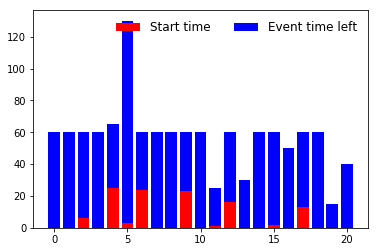

In [77]:
# Delay graph
values = [i['movementSegmentStartDelay'] for i in segments]
values2 =[i['duration'] - i['movementSegmentStartDelay'] for i in segments]
indices = np.arange(len(values))
p1 = plt.bar(indices, values, color='r')
p2 = plt.bar(indices, values2 , bottom=values, color='b')
plt.legend((p1[0], p2[0]), ("Start time", "Event time left"), fontsize=12, ncol=4, framealpha=0, fancybox=True)
plt.show()

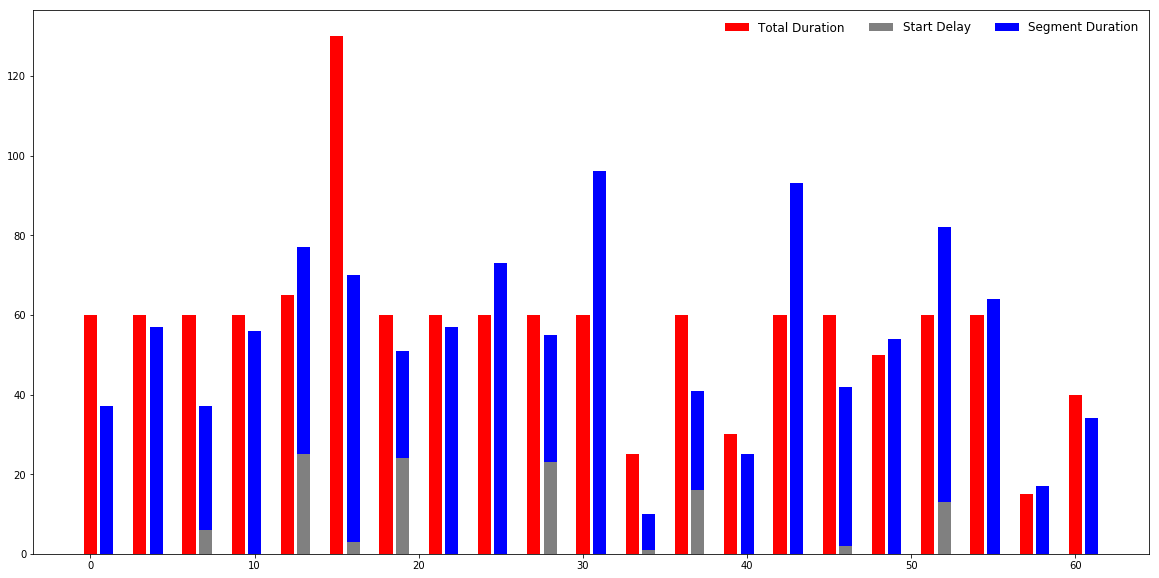

In [78]:
# Duration comparison 
plt.figure(figsize=(20,10))
eventDuration = [i['duration'] for i in segments]
segStart = [i['movementSegmentStartDelay'] for i in segments]
segDuration = [i['movementSegmentLength'] for i in segments]

indices = np.arange(len(values)*3,step=3)
p1 = plt.bar(indices, eventDuration, color='r')
p2 = plt.bar(indices+1, segStart, color='grey')
p3 = plt.bar(indices+1, segDuration , bottom=segStart, color='b')

plt.legend((p1[0], p2[0],p3[0]), ("Total Duration", "Start Delay", "Segment Duration"), fontsize=12, ncol=4, framealpha=0, fancybox=True)
plt.show()